In [9]:
%load_ext autoreload
%autoreload 2

import tikzplotlib

from sklearn.covariance import ledoit_wolf
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.utils.extmath import fast_logdet, randomized_svd, svd_flip
from torchvision import models, transforms

from meanshift import *

MVTEC_PATH="../../../../nas-files/mvtec"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
L = 5
log = []
P = 64
A = 80
s = 16
p = 1

for netname in ["raw", "vitb16", "eff", "res", "vgg"]: 
    
    if netname != "raw":
        net, layer_map = get_fmap(netname)
        net = net.to(device)
        net = net.eval()
    
    L = 7 if netname == "vitb16" else L
    L = 6 if netname == "res" else L
    L = 6 if netname == "vgg" else L
    L = 5 if netname == "eff" else L
    blocks = [L, L+1] if netname == "eff" else [L]
    
    r = int( (A - P)/s + 1 )
    
    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH)
        
        if netname == "raw":
            net, layer_map = get_pca(X_, 1.0, P, s)
            net = net.to(device)
            net = net.eval()

        if netname == "vitb16":
            X = patches_to_feature_space_vit(X_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
            X_valid = patches_to_feature_space_vit(X_valid_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
            X_test = patches_to_feature_space_vit(X_test_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        else:
            X = patches_to_feature_space(X_, net, P, s, blocks=blocks, layer_map=layer_map)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks, layer_map=layer_map)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks, layer_map=layer_map)
        
        print(X.shape)
                
        for run in range(5):
            
            for n in [1, 5, 10, 25, 50, 80, 100]:

                mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)
                
                
                auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                log.append(pd.DataFrame(np.asarray([run, netname, clazz, A, P, blocks[0], n, r, auc, auc_local])[:, None].T, columns=["run", "netname", "class", "A", "P", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(log[-1])
        torch.save(log, "backup3.log")


(209, 12288, 11, 11)


,run,netname,class,A,P,layers,n_samples,rho,auc,auc_local
0,1,raw,0,80,64,5,100,2,0.792063492063492,0.7865079365079365


(280, 12288, 11, 11)


,run,netname,class,A,P,layers,n_samples,rho,auc,auc_local
0,1,raw,1,80,64,5,100,2,0.3398876404494382,0.5228731942215088


(245, 12288, 11, 11)


,run,netname,class,A,P,layers,n_samples,rho,auc,auc_local
0,1,raw,2,80,64,5,100,2,0.5186820652173914,0.8906249999999999


(267, 12288, 11, 11)


,run,netname,class,A,P,layers,n_samples,rho,auc,auc_local
0,1,raw,3,80,64,5,100,2,0.7315875613747954,0.8791598472449537


(230, 12288, 11, 11)


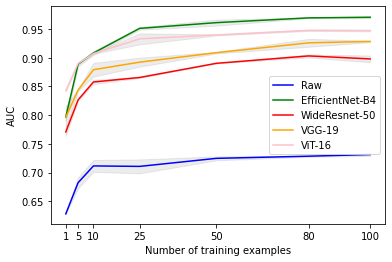

In [24]:
X_mean = [0.860 , 0.923 , 0.939 , 0.964 , 0.971 , 0.979 , 0.979]
X_std = [0.088, 0.050, 0.040, 0.023, 0.019, 0.014, 0.014]
x = [1, 5, 10, 25, 50, 80, 100]

names = ["Raw", "EfficientNet-B4", "WideResnet-50", "VGG-19", "ViT-16"]
colors = ["b", "g", "r", "orange", "pink"]
dat = pd.concat(torch.load("experiments/data_efficiency.log"))

for i, netname in enumerate(["raw", "eff", "res", "vgg", "vitb16"]):
    x = dat[dat["netname"] == netname][["run", "class", "auc_local", "n_samples"]].astype(np.float32).groupby("n_samples").mean().index
    y = dat[dat["netname"] == netname][["run", "class", "auc_local", "n_samples"]].astype(np.float32).groupby("n_samples").mean()["auc_local"]
    s = dat[dat["netname"] == netname][["run", "class", "auc_local", "n_samples"]].astype(np.float32).groupby(["run", "n_samples"]).mean().groupby([ "n_samples"]).std()["auc_local"]
    
    x, y, s = np.asarray(x), np.asarray(y), np.asarray(s)

    plt.plot(x, y, label=names[i], color=colors[i])
    plt.fill_between(x, y-s, y+s, color="grey", alpha=.15)
    
plt.xticks(x)
plt.ylabel("AUC")
plt.xlabel("Number of training examples")
plt.title("")
plt.legend()
tikzplotlib.save("tex/data_efficiency.tex")

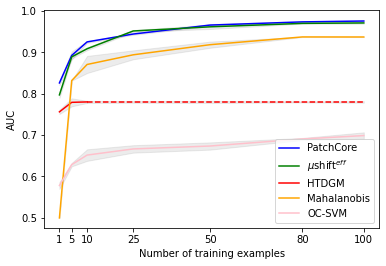

In [22]:
colors = ["b", "g", "r", "orange", "pink"]

x = [1, 5, 10, 25, 50, 80, 100]
y_patch_core = np.asarray([0.82582205, 0.8922442,  0.92482025, 0.94384729, 0.96549763, 0.97318691, 0.97529351])
s_patch_core = np.asarray([0.00517104, 0.0096512 , 0.00248153, 0.0019344 , 0.00240823, 0.00124494, 0.0018492])

plt.plot(x, y_patch_core, label="PatchCore", color=colors[0])
plt.fill_between(x, y_patch_core-s_patch_core, y_patch_core+s_patch_core, color="grey", alpha=.15)

dat = pd.concat(torch.load("experiments/data_efficiency.log"))
x = dat[dat["netname"] == "eff"][["run", "class", "auc_local", "n_samples"]].astype(np.float32).groupby("n_samples").mean().index
y = dat[dat["netname"] == "eff"][["run", "class", "auc_local", "n_samples"]].astype(np.float32).groupby("n_samples").mean()["auc_local"]
s = dat[dat["netname"] == "eff"][["run", "class", "auc_local", "n_samples"]].astype(np.float32).groupby(["run", "n_samples"]).mean().groupby([ "n_samples"]).std()["auc_local"]
x, y, s = np.asarray(x), np.asarray(y), np.asarray(s)
plt.plot(x, y, label="$\mu$shift$^{eff}$", color=colors[1])
plt.fill_between(x, y-s, y+s, color="grey", alpha=.15)


y_ht = np.asarray([0.756, 0.779,  0.780, 0.780, 0.780, 0.780, 0.780])
s_ht = np.asarray([0.00517104, 0.0096512 , 0.00248153, 0.0019344 , 0.00240823, 0.00124494, 0.0018492])

plt.plot(x[:3], y_ht[:3], label="HTDGM", color=colors[2])
plt.fill_between(x[:3], y_ht[:3]-s_ht[:3], y_ht[:3]+s_ht[:3], color="grey", alpha=.15)

plt.plot(x[2:], y_ht[2:], '--' , color=colors[2])
plt.fill_between(x[2:], y_ht[2:]-s_ht[2:], y_ht[2:]+s_ht[2:], color="grey", alpha=.15)


y_mh = np.asarray([0.5       , 0.831542  , 0.87037206, 0.89370525, 0.9181281 , 0.9368697 , 0.9367348 ])
s_mh = np.asarray([0.        , 0.00013533, 0.02060096, 0.01077063, 0.00744486, 0.00024028, 0.00020155])

plt.plot(x, y_mh, label="Mahalanobis", color=colors[3])
plt.fill_between(x, y_mh-s_mh, y_mh+s_mh, color="grey", alpha=.15)

y_mh = np.asarray([0.5781456 , 0.62865186, 0.6516684 , 0.6665207 , 0.6735555 , 0.6905192 , 0.69877046])
s_mh = np.asarray([0.00816637, 0.00409292, 0.01393459, 0.00899292, 0.00876924, 0.00249585, 0.00780391])

plt.plot(x, y_mh, label="OC-SVM", color=colors[4])
plt.fill_between(x, y_mh-s_mh, y_mh+s_mh, color="grey", alpha=.15)


plt.xticks(x)
plt.ylabel("AUC")
plt.xlabel("Number of training examples")
plt.title("")
plt.legend()
tikzplotlib.save("tex/data_efficiency_vs.tex")